In [ ]:
h_size = 10000
h_dt = 0.0005
t = np.arange(h_size*h_dt, step=h_dt)
cutoff = t < 0.02

freqs = np.fft.rfftfreq(h_size, d=h_dt)
desired = nengolib.signal.impulse(H, h_dt, h_size)

w, info = nengo.solvers.LstsqL2()(sim.data[p_synapses], Y)  # (*)

actual = np.zeros(h_size)
for i in range(n_neurons):
    imp = nengolib.signal.impulse(synapses[i], h_dt, h_size + 1)
    assert np.allclose(imp[0], 0)  # due to no passthrough
    actual += w[i] * imp[1:]

pylab.figure(figsize=(10, 5))
pylab.title("Derivative Impulse (Time Domain)")
pylab.plot(t[cutoff], desired[cutoff], label="Desired")
pylab.plot(t[cutoff], actual[cutoff], label="Actual*")
pylab.xlabel("Time ($s$)")
pylab.legend()
pylab.show()

pylab.figure(figsize=(10, 5))
pylab.title("Derivative Filter (Fourier Domain)")
pylab.plot(freqs, abs(np.fft.rfft(desired)), label="Desired")
pylab.plot(freqs, abs(np.fft.rfft(actual)), label="Actual*")
pylab.xlabel("Frequency ($Hz$)")
pylab.legend(loc='center right')
pylab.show()


freqs = np.fft.rfftfreq(size, d=h_dt)
H_hat = np.zeros(len(freqs))
for i in range(n_neurons):
    H_hat += abs(np.fft.rfft(nengolib.signal.impulse(synapses[i], h_dt, size))) * encoders[i, 0] * D[i, 0]

pylab.figure()
pylab.title("Filters (Fourier Domain)")
pylab.plot(freqs, H_hat / tau_derivative, label="Actual*")
pylab.plot(freqs, abs(np.fft.rfft(nengolib.signal.impulse(H, h_dt, h_size))), label="Desired")
pylab.xlabel("Frequency ($Hz$)")
pylab.ylabel("Power")
pylab.legend(loc='best')
pylab.show()

In [ ]:

#from nengolib.signal import s
#synapses = [(0.01*s + 1)/(tau*s + 1) for tau in taus]

In [295]:
%pylab inline

import nengolib
import numpy

import nengo

t = 0.04
tau = 0.005
n_neurons = 100

with nengo.Network() as model:
    stim = nengo.Node(output=1.0)
    x = nengo.Ensemble(n_neurons, 1, encoders=[[1]]*n_neurons, neuron_type=nengolib.PerfectLIF(tau_ref=0.002))
    nengo.Connection(stim, x, synapse=None)
    p_filt = nengo.Probe(x.neurons, synapse=tau)
    p_spike = nengo.Probe(x.neurons, synapse=None)
    p_ref = nengo.Probe(x.neurons, 'refractory_time', synapse=None)

dt = 0.0001
sim = nengo.Simulator(model, dt=dt)
sim.run(t)

print sim.data[p_filt][-1]
#print np.sum(sim.data[p_spike] > 0, axis=0) / t

print sim.data[x].max_rates


Populating the interactive namespace from numpy and matplotlib
Simulation finished in 0:00:01.                                                 
[ 296.44970846  233.65536942  317.31615663  380.10199678  181.18192907
  297.80558191  418.30195751  486.96889148  237.18565012  268.99096103
  188.1926264   214.14934804  276.34540298  252.21204413  240.2659157
  193.60727224  265.1244052   341.4936952   292.32179278  276.4989617
  270.75865975  358.55998777  321.52268203  300.48389729  296.44970846
  335.44400781  409.30705374  280.15557486  344.99630836  374.58924193
  371.54945566  409.87050621  220.41663969  371.54945566  250.79006467
  303.6000444   294.95596774  328.49369509  336.35065767  157.32033666
  365.42298317  255.96281238  237.18565012  319.89950431  263.85545688
  278.95073344  289.73833544  358.55998777  282.3477474   273.27621538
  213.52266243  226.11254783  271.06887446  238.35987958  321.98908412
  188.37634519  410.32427122  270.38076644  217.37915989  256.15555271
  199.

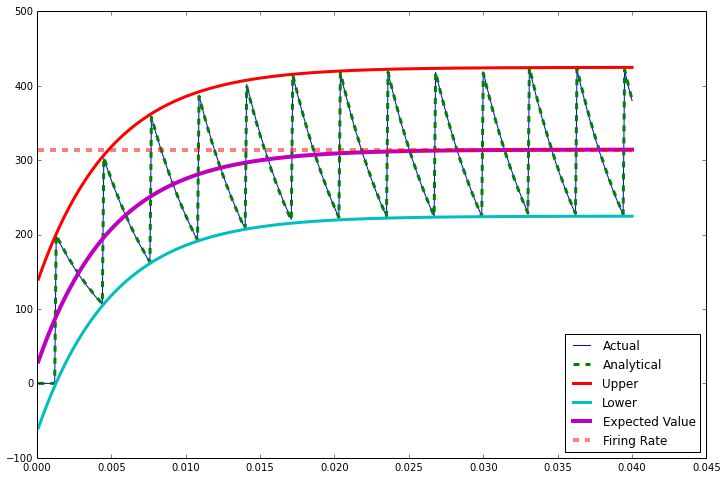

278.346565888
277.96079415


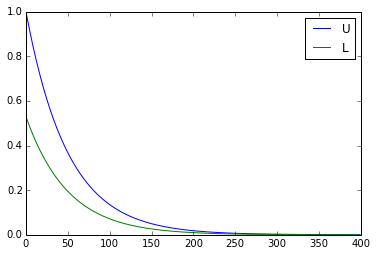

In [317]:
i = 3
t = sim.trange() - dt #+ 20*dt
a = sim.data[x].max_rates[i]
#tau = 0.05

#print a*t - m
J = sim.data[x].gain[i]*(sim.data[x].encoders[i]*1) + sim.data[x].bias[i]
s = -x.neuron_type.tau_rc * np.log((J - 1)/J)

trunc = a*(t - s) - np.floor(a*(t - s))
rt = np.exp(-(t - s + 1/a)/tau)
r = np.exp(-1/(a*tau))


pylab.figure(figsize=(12, 8))
pylab.plot(sim.trange(), sim.data[p_filt][:, i], label="Actual")
pylab.plot(sim.trange(), 1./tau * (r**trunc - rt)/(1 - r), linestyle='--', lw=3, label="Analytical")
pylab.plot(sim.trange(), 1./tau * (1 - rt)/(1 - r), lw=3, label='Upper')
pylab.plot(sim.trange(), 1./tau * (r - rt)/(1 - r), lw=3, label='Lower')
pylab.plot(sim.trange(), 1./tau * ((1 - r)*a*tau - rt)/(1 - r), lw=4, label='Expected Value')
#pylab.plot(sim.trange(), 1./tau * ((1 - r)*a*tau - np.exp(-t/tau))/(1 - r), lw=4, label='Expected Value')

pylab.plot(sim.trange(), np.repeat(sim.data[x].max_rates[None, i], len(sim.trange()), axis=0), lw=4, linestyle='--', c='red', alpha=0.5, label='Firing Rate')
pylab.legend(loc='best')
pylab.show()

print np.mean(1./tau * (e - rt)/(1 - r))
print np.mean(sim.data[p_filt][:, i])

pylab.figure()
pylab.plot(r**(t*a), label="U")
pylab.plot(r**(t*a + 1), label="L")
pylab.legend()
pylab.show()

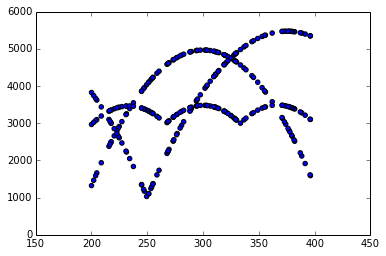

In [318]:

pylab.figure()

for t in (0.005, 1/250.0, 0.015):
    datax = []
    datay = []
    for i in range(n_neurons):
        a = sim.data[x].max_rates[i]
        s = linspace(0, 1/a, 100000)
        trunc = a*(t - s) - np.floor(a*(t - s))
        r = np.exp(-1/(a*tau))
        k = np.floor(a*t)

        datax.append(a)
        datay.append(np.var(((1 / tau) * (1 / (1 - r)) * (r**trunc - r**(a*(t - s) + 1)))))

    pylab.scatter(datax, datay)
pylab.show()

0.565670929528 0.565663491672
8.88871418875e-07 8.88870250216e-07
0.000674646020408 0.000674645794261
3315.15261255 3315.18548854
3315.18548854
3315.18548854
0.000674645794261
0.000674646020408
0.000515840013545
0.000709085870341
0.0009747261909
313.893515748 313.893568291
2452828.21449


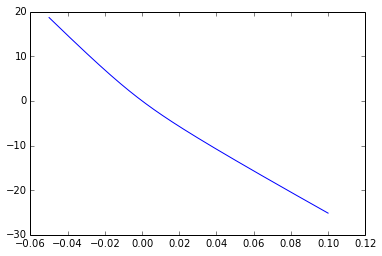

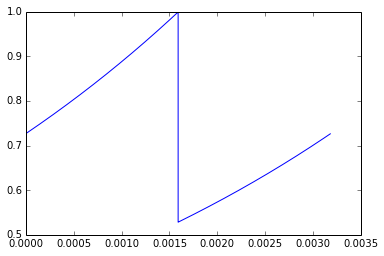

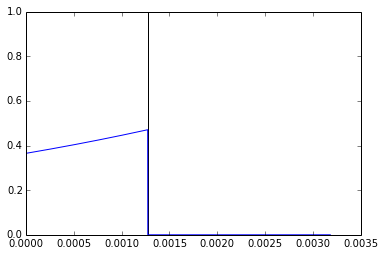

In [367]:
'''s = 0.2/a  # linspace(0, 1/a, 10000)
t = linspace(0, 3/a, 10000)  # 0.9/a
trunc = a*(t - s) - np.floor(a*(t - s))



pylab.figure()# figsize=(14, 9))
pylab.plot(t, r**trunc - r**(a*(t - s) + 1))
pylab.plot(t, r**trunc)
pylab.plot(t, - r**(a*(t - s) + 1))
pylab.show()'''

a = sim.data[x].max_rates[3]

s = linspace(0, 1/a, 100000)
t = 10.5/a
trunc = a*(t - s) - np.floor(a*(t - s))
r = np.exp(-1/(a*tau))
k = np.floor(a*t)

eps = -40.0
z = (1 - r)*tau*(a - eps)
floor = np.floor(t*a) + 1
s_cut = tau*np.log(z/(r**-floor - 1)) + 1/a + t

print np.mean(r**(2*np.linspace(0, 1, 10000))), a*tau/2 * (1 - r**2)

print np.mean(r**(2*(a*(t - s) + 1))), a*tau/2 * (r**(2*a*t) - r**(2*a*t+2))

print np.mean(r**(2*(a*(t - s) + 1) - np.floor(a*(t - s) + 1))), a*tau/2 * (r**(k + 1) - r**(k + 2) + r**(2*a*t - k)*(1 - r))

print np.var(((1 / tau) * (1 / (1 - r)) * (r**trunc - r**(a*(t - s) + 1)))),  a / (2*tau*(1 - r)**2) * ((1 - r**2) * (1 + r**(2*a*t)) - 2*(1 - r)*(r**(k+1) + r**(2*a*t - k))) - a**2 * (1 - r**(a*t))**2

print a / (2*tau*(1 - r)**2) * ((1 - r**2) * (1 + r**(2*a*t)) - 2*(1 - r)*(r**(k+1) + r**(2*a*t - k))) - a**2 * (1 - r**(a*t))**2
print a * ((1 - r**2) * (1 + r**(2*a*t)) / (2*tau*(1 - r)**2) - (r**(k+1) + r**(2*a*t - k)) / (tau*(1 - r)) - a * (1 - r**(a*t))**2)

print a*tau*(1 - r)*(r**(k+1) + r**(2*a*t - k))/2
print np.mean(r**(2*(a*(t - s) + 1) - np.floor(a*(t - s) + 1)))
print np.mean(r**(2*(a*(t - s) + 1) - (k + 0)))
print np.mean(r**(2*(a*(t - s) + 1) - (k + 0.5)))
print np.mean(r**(2*(a*(t - s) + 1) - (k + 1.0)))


a_est = ((1 / tau) * (1 / (1 - r)) * (r**trunc - r**(a*(t - s) + 1)))
print np.mean(a_est), a*(1 - np.exp(-t/tau))

t_ch = np.linspace(-0.05, 0.1, 200)
chernoff = np.exp(-t_ch[:, None]*a_est[None, :])
print np.mean(chernoff)
pylab.figure()
pylab.plot(t_ch, np.log(np.mean(chernoff, axis=1)))
pylab.show()

p = 250
#print np.exp(t*p) * (np.mean(chernoff))**100

pylab.figure()
#pylab.plot(s, a_est)
#pylab.plot(s, r**(2*(a*(t - s) + 1) - np.floor(a*(t - s) + 1)))
#pylab.plot(s, np.floor(a*(t - s) + 1))
#pylab.vlines([t  - np.floor(a*t)/a], 0, 1000)
pylab.show()

pylab.figure()
pylab.plot(s, r**trunc - r**(a*(t - s) + 1))
#pylab.plot(s, np.repeat(r**(a*t) * (1 - r), len(s)))
#pylab.plot(s, np.repeat((1 - r), len(s)))
#pylab.vlines([t % (1/a), s_cut], 0, 1)
#pylab.plot(s, np.repeat(z, len(s)))
pylab.show()

s = linspace(0, 1/a, 10000)
t = 0.4/a
trunc = a*(t - s) - np.floor(a*(t - s))

pylab.figure()
pylab.plot(s, r**trunc - r**(a*(t - s) + 1))
pylab.vlines([t % (1/a)], 0, 1)  # ((t+1) % (1/a))
#t -= (t % (1/a))
#trunc = a*(t - s) - np.floor(a*(t - s))
#pylab.plot(s, r**trunc - r**(a*(t - s) + 1))
pylab.show()


In [ ]:
t_keep = sim.trange() > T_init

t = sim.trange()[t_keep] - T_init  # compensate for probe/connection delays
#a_0 = nengo.builder.ensemble.get_activities(sim.model, ens, [0])

data = []
no_fire = 0
for i in range(n_neurons):
    if a[i] > 0:
        w = np.where(sim.data[p_spikes][t_keep, i] > 0)[0]        
        j = sim.trange()[w[0]] * a[i]
        #if j <= 1:
        data.append(j)
    else:
        no_fire += 1
        
        print no_fire, "/", n_neurons

pylab.figure()
sns.kdeplot(np.asarray(data), cumulative=False, clip=(0, 1))
#pylab.hist(data, bins=100)
pylab.show()
print min(data), max(data)